In [1]:
# Importacion de librerias
# Conexión a la base de datos
# ==========================================
import os
import sys
import pathlib


sys.path.append(
    os.path.join(pathlib.Path(os.getcwd()).parent)
)
from utils.bq_conn import bq_conn_file

bq_client = bq_conn_file(project_id="dsa-miad-365616")

# Tratamiento de datos
# ==========================================
import pandas as pd
import numpy as np
from datetime import datetime

# Graficas
# ==========================================
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Modelos ML
# ==========================================
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from IPython.display import display



## Importo data

In [2]:
pd.options.display.max_columns = None

query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''
bq_client = bq_conn_file(project_id="dsa-miad-365616")
secop_I = bq_client.execute_query(query=query)
print(f"El número de filas del dataset: {secop_I.shape[0]}\nEl número de columnas del dataset: {secop_I.shape[1]}")
secop_I.head(5)

El número de filas del dataset: 26553
El número de columnas del dataset: 38


,uid,anno_cargue_secop,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,departamento_ejecucion,numero_de_proceso,numero_de_contrato,cuantia_proceso,id_grupo,nombre_grupo,id_familia,nombre_familia,id_clase,nombre_clase,id_adjudicacion,tipo_identifi_del_contratista,identificacion_del_contratista,nom_razon_social_contratista,tipo_doc_representante_legal,identific_representante_legal,plazo_de_ejec_del_contrato_,dias_ejec_final_contrato,rango_de_ejec_del_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
0,191389136418143424,2019,13,contratacion minima cuantia,celebrado,50000000,contratar servicio suministro elementos materi...,suministro,facatativa,facatativa,cundinamarca,CPMMSFFAMCNo01DE2019,CPMMSFFAMCNO01DE2019,50000000,E,productos de uso final,5022,productos de cereales legumbres,502213,harina productos de molinos,8143424,nit de persona juridica,900791326,inversiones ocazo,cedula de ciudadania,1022363447,330,330,D,0,0,50000000,0,0,50000000,peso colombiano,contratar compra elementos materia prima para ...,{'url': 'https://www.contratos.gov.co/consulta...
1,1912101041779226352,2019,12,contratacion directa ley de,celebrado,53000000,adquisicion uniformes para dotar personal cuer...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA184DE2019,184DE2019,22980096902,E,productos de uso final,5310,ropa,531027,uniformes,9226352,nit de persona juridica,860020227,fondo rotatorio de la policia forpo,nit de persona juridica,860020227,660,690,D,1,30,22980096902,0,0,22980096902,peso colombiano,adquisicion uniformes para dotar personal cuer...,{'url': 'https://www.contratos.gov.co/consulta...
2,1912101443259265538,2019,12,contratacion directa ley de,celebrado,55000000,contratar diseno produccion tarjetas presentac...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA188DE2019,188DE2019,35998452,E,productos de uso final,5510,medios impresos,551015,publicaciones impresas,9265538,nit de persona juridica,830001113,imprenta nacional de colombia,nit de persona juridica,830001113,31,71,D,1,40,35998452,0,0,35998452,peso colombiano,contratar diseno produccion tarjetas presentac...,{'url': 'https://www.contratos.gov.co/consulta...
3,191294985788644918,2019,12,contratacion directa ley de,liquidado,72000000,prestar servicio mantenimiento preventivo corr...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA106DE2019,106DE2019,16767536,F,servicios,7210,servicios de mantenimiento reparaciones de con...,721015,servicios de apoyo para la construccion,8644918,nit de persona juridica,860025639,mitsubishi electric de colombia limitada,nit de persona juridica,860025639,170,170,D,0,0,16767536,0,0,16767536,peso colombiano,prestar servicio mantenimiento preventivo corr...,{'url': 'https://www.contratos.gov.co/consulta...
4,191988590538059861,2019,19,asociacion publico privada,celebrado,73000000,desintegracion vehiculos automotores estado in...,no encontrado en hoja proceso,bogota,bogota,bogota,CONVENIODEASOCIACIÓN231DE2018,231DE2018,0,F,servicios,7318,servicios de maquinado procesado,731810,servicios de maquinado,8059861,nit de persona juridica,806011019,recuperaciones naranjo recycling sas,cedula de ciudadania,57439563,360,360,D,0,0,0,0,0,0,peso colombiano,desintegracion vehiculos automotores estado in...,{'url': 'https://www.contratos.gov.co/consulta...


In [3]:
secopI_filter = secop_I.filter(items=['tipo_de_contrato', 
                'id_grupo', 
                'cuantia_proceso',
                'departamento_ejecucion',
                'plazo_de_ejec_del_contrato_',
                'id_objeto_a_contratar',
                'tiempo_adiciones_en_dias',
                                      ])
secopI_filter.head(5)

,tipo_de_contrato,id_grupo,cuantia_proceso,departamento_ejecucion,plazo_de_ejec_del_contrato_,id_objeto_a_contratar,tiempo_adiciones_en_dias
0,suministro,E,50000000,cundinamarca,330,50000000,0
1,prestacion de servicios,E,22980096902,bogota,660,53000000,30
2,prestacion de servicios,E,35998452,bogota,31,55000000,40
3,prestacion de servicios,F,16767536,bogota,170,72000000,0
4,no encontrado en hoja proceso,F,0,bogota,360,73000000,0


In [4]:
# casteo de las variables
secopI_filter['tipo_de_contrato'] = secopI_filter['tipo_de_contrato'].astype('category')
secopI_filter['departamento_ejecucion'] = secopI_filter['departamento_ejecucion'].astype('category')
secopI_filter['id_objeto_a_contratar'] = secopI_filter['id_objeto_a_contratar'].astype('category')
secopI_filter['cuantia_proceso'] = secopI_filter['cuantia_proceso'].astype('int')
secopI_filter['plazo_de_ejec_del_contrato_'] = secopI_filter['plazo_de_ejec_del_contrato_'].astype('int')
secopI_filter['tiempo_adiciones_en_dias'] = secopI_filter['tiempo_adiciones_en_dias'].astype('int')

In [5]:
secopI_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26553 entries, 0 to 26552
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   tipo_de_contrato             26553 non-null  category
 1   id_grupo                     26553 non-null  object  
 2   cuantia_proceso              26553 non-null  int64   
 3   departamento_ejecucion       26553 non-null  category
 4   plazo_de_ejec_del_contrato_  26553 non-null  int64   
 5   id_objeto_a_contratar        26553 non-null  category
 6   tiempo_adiciones_en_dias     26553 non-null  int64   
dtypes: category(3), int64(3), object(1)
memory usage: 911.9+ KB


In [6]:
input_model = secopI_filter[['tipo_de_contrato', 
                'id_grupo', 
                'cuantia_proceso',
                'departamento_ejecucion',
                'plazo_de_ejec_del_contrato_',
                'id_objeto_a_contratar',
                ]]

input_model.head()

,tipo_de_contrato,id_grupo,cuantia_proceso,departamento_ejecucion,plazo_de_ejec_del_contrato_,id_objeto_a_contratar
0,suministro,E,50000000,cundinamarca,330,50000000
1,prestacion de servicios,E,22980096902,bogota,660,53000000
2,prestacion de servicios,E,35998452,bogota,31,55000000
3,prestacion de servicios,F,16767536,bogota,170,72000000
4,no encontrado en hoja proceso,F,0,bogota,360,73000000


## Preprocesamiento - Pipeline y ColumnTransformer


Las clases ColumnTransformer y make_column_transformer del módulo sklearn.compose permiten combinar múltiples transformaciones de preprocesado, especificando a qué columnas se aplica cada una. Como todo transformer, tiene un método de entrenamiento (fit) y otro de transformación (transform) . Esto permite que el aprendizaje de las transformaciones se haga únicamente con observaciones de entrenamiento, y se puedan aplicar después a cualquier conjunto de datos. La idea detrás de este módulo es la siguiente:

Definir todas las transformaciones (escalado, selección, filtrado...) que se desea aplicar y a qué columnas ColumnTransformer(). La selección de columnas puede hacerse por: nombre. índice, máscara booleana, slice, patrón regex, por tipo de columna o con las funciones de selección make_column_selector.

Aprender los parámetros necesarios para dichas transformaciones con las observaciones de entrenamiento .fit().

Aplicar las transformaciones aprendidas a cualquier conjunto de datos .transform().

In [7]:
numeric_cols = input_model.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = input_model.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               ).set_output(transform="pandas")

data_prep = preprocessor.fit_transform(input_model)

In [8]:
from pickle import dump
# save the scaler
#dump(preprocessor, open('app_tools/utils/preprocessor_tiempo.pkl', 'wb'))

In [9]:
pd.options.display.max_columns = None
output = secopI_filter[['tiempo_adiciones_en_dias']]
data_prep_final = pd.concat([data_prep,output],axis=1)
data_prep_final

,cuantia_proceso,plazo_de_ejec_del_contrato_,tipo_de_contrato_acuerdo marco,tipo_de_contrato_arrendamiento,tipo_de_contrato_comodato,tipo_de_contrato_compraventa,tipo_de_contrato_concesion,tipo_de_contrato_consultoria,tipo_de_contrato_no encontrado en hoja proceso,tipo_de_contrato_obra,tipo_de_contrato_otro tipo de contrato,tipo_de_contrato_prestacion de servicios,tipo_de_contrato_suministro,id_grupo_A,id_grupo_B,id_grupo_C,id_grupo_D,id_grupo_E,id_grupo_F,id_grupo_G,departamento_ejecucion_amazonas,departamento_ejecucion_antioquia,departamento_ejecucion_arauca,departamento_ejecucion_atlantico,departamento_ejecucion_bogota,departamento_ejecucion_bolivar,departamento_ejecucion_boyaca,departamento_ejecucion_caldas,departamento_ejecucion_caqueta,departamento_ejecucion_casanare,departamento_ejecucion_cauca,departamento_ejecucion_cesar,departamento_ejecucion_choco,departamento_ejecucion_colombia,departamento_ejecucion_cordoba,departamento_ejecucion_cundinamarca,departamento_ejecucion_huila,departamento_ejecucion_la guajira,departamento_ejecucion_magdalena,departamento_ejecucion_meta,departamento_ejecucion_narino,departamento_ejecucion_norte de santander,departamento_ejecucion_otros paises,departamento_ejecucion_putumayo,departamento_ejecucion_quindio,departamento_ejecucion_risaralda,departamento_ejecucion_san andres,departamento_ejecucion_santander,departamento_ejecucion_sucre,departamento_ejecucion_tolima,departamento_ejecucion_valle del cauca,id_objeto_a_contratar_10000000,id_objeto_a_contratar_11000000,id_objeto_a_contratar_12000000,id_objeto_a_contratar_13000000,id_objeto_a_contratar_14000000,id_objeto_a_contratar_15000000,id_objeto_a_contratar_20000000,id_objeto_a_contratar_21000000,id_objeto_a_contratar_22000000,id_objeto_a_contratar_23000000,id_objeto_a_contratar_24000000,id_objeto_a_contratar_25000000,id_objeto_a_contratar_26000000,id_objeto_a_contratar_27000000,id_objeto_a_contratar_30000000,id_objeto_a_contratar_31000000,id_objeto_a_contratar_32000000,id_objeto_a_contratar_39000000,id_objeto_a_contratar_40000000,id_objeto_a_contratar_41000000,id_objeto_a_contratar_42000000,id_objeto_a_contratar_43000000,id_objeto_a_contratar_44000000,id_objeto_a_contratar_45000000,id_objeto_a_contratar_46000000,id_objeto_a_contratar_47000000,id_objeto_a_contratar_48000000,id_objeto_a_contratar_49000000,id_objeto_a_contratar_50000000,id_objeto_a_contratar_51000000,id_objeto_a_contratar_52000000,id_objeto_a_contratar_53000000,id_objeto_a_contratar_54000000,id_objeto_a_contratar_55000000,id_objeto_a_contratar_56000000,id_objeto_a_contratar_60000000,id_objeto_a_contratar_70000000,id_objeto_a_contratar_71000000,id_objeto_a_contratar_72000000,id_objeto_a_contratar_73000000,id_objeto_a_contratar_76000000,id_objeto_a_contratar_77000000,id_objeto_a_contratar_78000000,id_objeto_a_contratar_80000000,id_objeto_a_contratar_81000000,id_objeto_a_contratar_82000000,id_objeto_a_contratar_83000000,id_objeto_a_contratar_84000000,id_objeto_a_contratar_85000000,id_objeto_a_contratar_86000000,id_objeto_a_contratar_90000000,id_objeto_a_contratar_91000000,id_objeto_a_contratar_92000000,id_objeto_a_contratar_93000000,id_objeto_a_contratar_94000000,id_objeto_a_contratar_95000000,tiempo_adiciones_en_dias
0,0.183652,1.831428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,138.304964,4.239830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Conjunto de datos en *train* y *test*

Se particiona el conjunto de datos dos subconjuntos de datos, *train* que es el conjunto de datos utilizados para entrenar los modelos el cual representa el 80% de los datos totales y *test* para comprobar el rendimiento de los modelos que representa el 20% restante.  

In [10]:
# conjunto de datos train
train_datos = data_prep_final.sample(frac=0.9, random_state=0)
# conjunto de datos test
test_datos = input_model.drop(train_datos.index)

## Modelos Regresión

In [18]:
# import pycaret regression and init setup
from pycaret.regression import *
s = setup(train_datos, 
          #pca=True,
          target = 'tiempo_adiciones_en_dias', 
          feature_selection=True, 
          fold=5, train_size= 0.95,
          preprocess=True,
          session_id = 123)
models()

,Description,Value
0,Session id,123
1,Target,tiempo_adiciones_en_dias
2,Target type,Regression
3,Original data shape,"(23898, 108)"
4,Transformed data shape,"(23898, 22)"
5,Transformed train set shape,"(22703, 22)"
6,Transformed test set shape,"(1195, 22)"
7,Numeric features,107
8,Preprocess,True
9,Imputation type,simple


,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [19]:
# compare models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.8251,68.9787,8.2564,0.2682,0.7595,0.7743,0.2000
catboost,CatBoost Regressor,1.8895,72.2846,8.4224,0.2373,0.7650,0.7695,0.1820
gbr,Gradient Boosting Regressor,1.8719,72.6177,8.4493,0.2342,0.7638,0.8094,0.1800
xgboost,Extreme Gradient Boosting,1.9197,78.9623,8.8273,0.1613,0.7673,0.7776,0.1800
knn,K Neighbors Regressor,1.6220,79.2862,8.8711,0.1530,0.7165,0.8053,0.2460
rf,Random Forest Regressor,1.7345,80.4172,8.9068,0.1459,0.7434,0.7573,0.1920
et,Extra Trees Regressor,1.6710,91.3156,9.4956,0.0186,0.7144,0.7739,0.2000
br,Bayesian Ridge,2.5055,93.6530,9.6217,0.0059,0.9556,0.8875,0.1760
ridge,Ridge Regression,2.5194,93.7343,9.6261,0.0049,0.9599,0.8867,0.1720
lr,Linear Regression,2.5202,93.7442,9.6266,0.0048,0.9601,0.8866,0.1820


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [13]:
model_final = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.7947,65.9379,8.1202,0.2829,0.7661,0.7758
1,2.0152,81.5269,9.0292,0.1857,0.7972,0.7610
2,1.7547,53.2173,7.2950,0.3791,0.7458,0.7671
3,1.7998,90.7900,9.5284,0.2507,0.7233,0.7695
4,1.7609,53.4213,7.3090,0.2424,0.7652,0.7980
Mean,1.8251,68.9787,8.2564,0.2682,0.7595,0.7743
Std,0.0967,15.0525,0.9006,0.0637,0.0245,0.0128


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
predict_model(model_final)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.9031,78.6850,8.8705,0.1499,0.7931,0.8188


,cuantia_proceso,plazo_de_ejec_del_contrato_,tipo_de_contrato_acuerdo marco,tipo_de_contrato_arrendamiento,tipo_de_contrato_comodato,tipo_de_contrato_compraventa,tipo_de_contrato_concesion,tipo_de_contrato_consultoria,tipo_de_contrato_no encontrado en hoja proceso,tipo_de_contrato_obra,...,id_objeto_a_contratar_85000000,id_objeto_a_contratar_86000000,id_objeto_a_contratar_90000000,id_objeto_a_contratar_91000000,id_objeto_a_contratar_92000000,id_objeto_a_contratar_93000000,id_objeto_a_contratar_94000000,id_objeto_a_contratar_95000000,tiempo_adiciones_en_dias,prediction_label
14231,-0.028465,1.977392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.827934
15889,-0.045244,0.809682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.956168
3961,-0.075751,-0.503992,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.505841
22946,-0.115419,-0.467501,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.172727
6022,0.007763,0.955645,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.220925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10443,-0.062086,-0.576974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.039221
9663,-0.102468,-0.358028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.200836
2063,-0.096415,-0.248556,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.194936
19155,0.249911,0.736700,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.913482


In [20]:
# tune model maximizando el R2
r2_tuned = tune_model(model_final, optimize='R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3117,68.4959,8.2762,0.2551,0.9372,0.7612
1,2.4369,79.6901,8.9269,0.2040,0.9449,0.7607
2,2.2019,55.1795,7.4283,0.3562,0.9011,0.7967
3,2.2888,93.1792,9.6529,0.2310,0.8908,0.7905
4,2.2712,53.7971,7.3347,0.2371,0.9422,0.7907
Mean,2.3021,70.0684,8.3238,0.2567,0.9232,0.7800
Std,0.0767,14.9371,0.8846,0.0524,0.0226,0.0157


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [20]:
save_model(r2_tuned, model_name = '/Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tools/models/lightgbm_tiempo_adicion')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/var/folders/cy/6g84nnc90d3blx29rvlncq2c0000gn/T/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['cuantia_proceso',
                                              'plazo_de_ejec_del_contrato_',
                                              'tipo_de_contrato_acuerdo marco',
                                              'tipo_de_contrato_arrendamiento',
                                              'tipo_de_contrato_comodato',
                                              'tipo_de_contrato_compraventa',
                                              'tipo_de_contrato_concesion',...
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('feature_selection',
                  TransformerWrapper(exclude=[],
                                     transformer=SelectFromMod

## Analyze Model
The plot_model function is used to analyze the performance of a trained model on the test set. It may require re-training the model in certain cases.

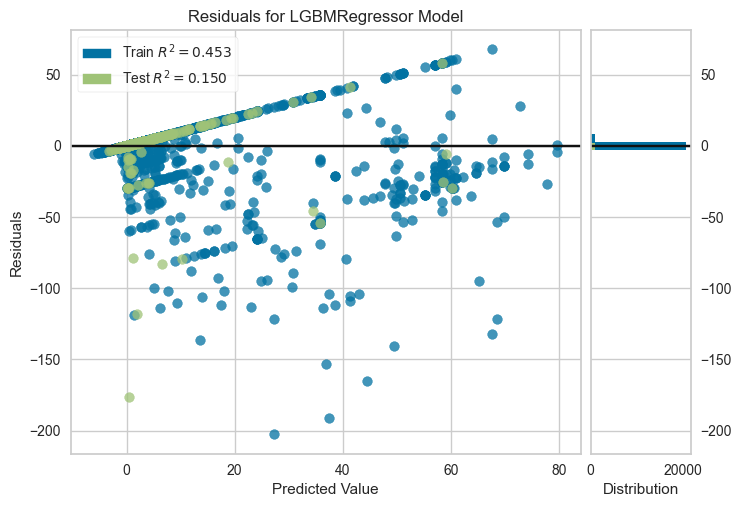

In [23]:
# plot residuals
plot_model(r2_tuned, plot = 'residuals')

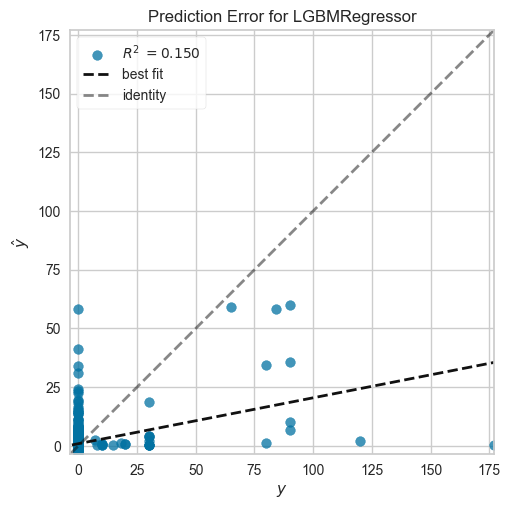

In [25]:
# plot error
plot_model(r2_tuned, plot = 'error')

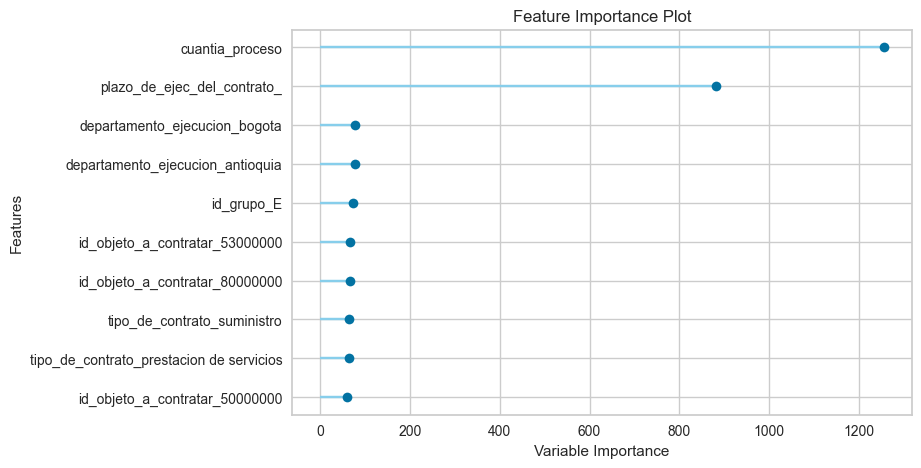

In [24]:
# plot feature importance
plot_model(r2_tuned, plot = 'feature')

In [ ]:
print(best)